# 1. Setup and Imports

In [1]:
# Section 1: Setup and Environment Configuration
# Purpose: Import libraries and configure environment

!pip install torch-fidelity
!pip install torchmetrics[image]
# Essential imports
import os
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import shutil
import random
import time
from torch.cuda.amp import autocast, GradScaler

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configure GPU memory management
if torch.cuda.is_available():
    # Limit memory usage to avoid fragmentation
    torch.cuda.empty_cache()
    
    # Optional: Set memory fraction to use
    # torch.cuda.set_per_process_memory_fraction(0.8)
    
    # Print GPU info
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Hyperparameters
config = {
    "latent_dim": 128,         # Size of generator input noise
    "image_size": 64,          # Training resolution
    "batch_size": 64,          # Batch size
    "lr_g": 0.0002,            # Generator learning rate
    "lr_d": 0.0001,            # Discriminator learning rate
    "beta1": 0.5,              # Adam optimizer beta1
    "beta2": 0.999,            # Adam optimizer beta2
    "n_epochs": 100,           # Number of training epochs
    "n_critic": 1,             # Number of discriminator updates per generator update
    "gp_lambda": 10,           # Gradient penalty coefficient
    "save_interval": 10,       # Epoch interval for saving models
    "eval_interval": 5,        # Epoch interval for evaluation
}

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory Available: 17.06 GB


In [2]:
!nvidia-smi

Tue Apr  1 10:37:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Dataset Handling

In [3]:
# Section 2: Dataset Loading and Preprocessing
# Purpose: Load and prepare gravitational lensing data

class LensingDataset(Dataset):
    """Custom dataset for gravitational lensing images"""
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        
        # Convert from numpy array to tensor if needed
        if isinstance(image, np.ndarray):
            # Handle single channel (grayscale) images
            if len(image.shape) == 2:
                image = image[..., np.newaxis]
                
            # Normalize to [0, 1] range if needed
            if image.dtype == np.uint8:
                image = image.astype(np.float32) / 255.0
            else:
                image = (image - image.min()) / (image.max() - image.min() + 1e-8)
                
            # Convert to tensor
            image = torch.from_numpy(image).float()
            
            # Rearrange to [C, H, W] format if needed
            if image.shape[-1] in [1, 3]:  # Channel last
                image = image.permute(2, 0, 1)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        return image

def load_data():
    """Load gravitational lensing dataset from Kaggle paths"""
    # Common path patterns in Kaggle
    kaggle_paths = [
        '/kaggle/input/diffusion-dataset/Samples'
    ]
    
    # Try loading .npy file directly
    for path in kaggle_paths:
        if os.path.exists(path) and path.endswith('.npy'):
            print(f"Loading dataset from {path}")
            data = np.load(path)
            return data
    
    # Try loading from directory of .npy files
    for path in kaggle_paths:
        if os.path.exists(path) and os.path.isdir(path):
            print(f"Loading .npy files from {path}")
            files = glob.glob(os.path.join(path, '*.npy'))
            
            if len(files) > 0:
                print(f"Found {len(files)} .npy files")
                
                # Load first file to determine dimensions
                sample = np.load(files[0])
                
                # Pre-allocate memory for all images
                if len(sample.shape) == 2:  # Single channel
                    data = np.zeros((len(files), sample.shape[0], sample.shape[1]), dtype=np.float32)
                    
                    # Load all files
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        data[i] = np.load(file)
                else:
                    data = np.zeros((len(files),) + sample.shape, dtype=np.float32)
                    
                    # Load all files
                    for i, file in enumerate(tqdm(files, desc="Loading files")):
                        data[i] = np.load(file)
                
                return data

def prepare_dataloaders(data, batch_size=64, image_size=64):
    """Prepare data loaders with proper preprocessing"""
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), antialias=True),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Map to [-1, 1] range
    ])
    
    # Create dataset
    dataset = LensingDataset(data, transform=transform)
    
    # Split into training and validation sets
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(seed)
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True,
        drop_last=True  # Important for batch normalization
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    return train_loader, val_loader

def visualize_samples(data, num_samples=16, title="Dataset Samples"):
    """Visualize samples from the dataset"""
    # Select random indices
    if isinstance(data, np.ndarray):
        indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
        samples = data[indices]
        
        # Create a figure
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        axes = axes.flatten()
        
        for i, (ax, img) in enumerate(zip(axes, samples)):
            # Process image for display
            if len(img.shape) == 3 and img.shape[0] == 1:  # CHW format
                img = img[0]  # Remove channel dimension
            elif len(img.shape) == 3 and img.shape[-1] == 1:  # HWC format
                img = img[..., 0]  # Remove channel dimension
                
            # Normalize for visualization
            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            ax.imshow(img_norm, cmap='viridis')
            ax.set_title(f"Sample {i+1}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.suptitle(title)
        plt.show()
    else:
        # Handle tensor data
        grid_img = vutils.make_grid(data[:num_samples], nrow=4, normalize=True).cpu()
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.title(title)
        plt.axis('off')
        plt.show()


# 3. Generator Architecture

In [4]:
# Section 3: Generator Architecture
# Purpose: Define the GAN generator network

# Import PyTorch's spectral_norm
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    """DCGAN-style Generator for gravitational lensing images"""
    def __init__(self, latent_dim=128, img_size=64, channels=1):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        self.img_size = img_size
        
        # Calculate initial feature map size
        self.init_size = img_size // 16  # 4 upsampling operations: 2^4 = 16
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size * self.init_size)
        )
        
        self.conv_blocks = nn.Sequential(
            # Block 1: (init_size x init_size x 128) -> (init_size*2 x init_size*2 x 128)
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 2: (init_size*2 x init_size*2 x 128) -> (init_size*4 x init_size*4 x 64)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: (init_size*4 x init_size*4 x 64) -> (init_size*8 x init_size*8 x 32)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: (init_size*8 x init_size*8 x 32) -> (init_size*16 x init_size*16 x channels)
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, channels, 3, stride=1, padding=1),
            nn.Tanh()  # Output range: [-1, 1]
        )
        
        # Apply weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
                
    def forward(self, z):
        # Project and reshape latent vector
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        # Apply convolution blocks
        img = self.conv_blocks(out)
        return img

# 4. Discriminator Architecture


In [5]:
class Discriminator(nn.Module):
    """PatchGAN-style Discriminator for gravitational lensing images"""
    def __init__(self, img_size=64, channels=1):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns discriminator layers with spectral normalization"""
            block = [
                spectral_norm(nn.Conv2d(in_filters, out_filters, 3, 2, 1)),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        
        # Initial layers without batch normalization
        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        
        # Calculate size of output feature maps
        ds_size = img_size // 2**4  # 4 downsampling operations
        
        # Output layer for classification with spectral norm
        self.adv_layer = nn.Sequential(
            spectral_norm(nn.Linear(128 * ds_size * ds_size, 1))
            # No sigmoid - will use BCEWithLogitsLoss
        )
        
        # Apply weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if not hasattr(m, 'weight_orig'):  # Skip layers that already have spectral norm
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
    
    def forward(self, img):
        # Feature extraction
        features = self.model(img)
        # Global average pooling or flattening
        features = features.contiguous().view(features.shape[0], -1)  #features = features.reshape(features.shape[0], -1)
        # Classification
        validity = self.adv_layer(features)
        
        return validity


# 5. Training Utilities


In [6]:
# Section 5: Training Utilities
# Purpose: Define loss functions and training helpers

def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    # Random interpolation factor
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    
    # Interpolated images
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get discriminator output for interpolated images
    d_interpolates = discriminator(interpolates)
    
    # Compute gradient w.r.t. interpolates
    fake = torch.ones(real_samples.size(0), 1, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

class DiffAugment:
    """Differentiable augmentation for GANs"""
    @staticmethod
    def augment(x, policy='color,translation,cutout'):
        if policy:
            if 'color' in policy:
                x = DiffAugment._color(x)
            if 'translation' in policy:
                x = DiffAugment._translation(x)
            if 'cutout' in policy:
                x = DiffAugment._cutout(x)
        return x
    
    @staticmethod
    def _color(x):
        batch_size = x.size(0)
        colors = torch.randn(batch_size, 3, 1, 1, device=x.device)
        colors = colors / colors.norm(dim=1, keepdim=True) * 0.05
        if x.size(1) == 1:  # Grayscale to RGB for color augmentation
            x_c3 = x.repeat(1, 3, 1, 1)
            x_c3 = x_c3 * (1 + colors)
            return x_c3.mean(dim=1, keepdim=True)  # Back to grayscale
        else:
            return x * (1 + colors)
    
    @staticmethod
    def _translation(x, ratio=0.125):
        batch_size = x.size(0)
        shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
        translation_x = torch.randint(-shift_x, shift_x + 1, size=[batch_size, 1, 1], device=x.device)
        translation_y = torch.randint(-shift_y, shift_y + 1, size=[batch_size, 1, 1], device=x.device)
        grid_batch, grid_x, grid_y = torch.meshgrid(
            torch.arange(batch_size, device=x.device),
            torch.arange(x.size(2), device=x.device),
            torch.arange(x.size(3), device=x.device),
            indexing='ij'
        )
        grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
        grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
        x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
        x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
        return x
    
    @staticmethod
    def _cutout(x, ratio=0.5):
        batch_size = x.size(0)
        cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
        offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[batch_size, 1, 1], device=x.device)
        offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[batch_size, 1, 1], device=x.device)
        grid_batch, grid_x, grid_y = torch.meshgrid(
            torch.arange(batch_size, device=x.device),
            torch.arange(cutout_size[0], device=x.device),
            torch.arange(cutout_size[1], device=x.device),
            indexing='ij'
        )
        grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
        grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
        mask = torch.ones(x.size(0), x.size(2), x.size(3), device=x.device)
        mask[grid_batch, grid_x, grid_y] = 0
        return x * mask.unsqueeze(1)

class EMA:
    """Exponential Moving Average for model weights"""
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


# 6. Training Loop


In [7]:
# Section 6: Training Loop
# Purpose: Implement GAN training procedure

def train_gan(generator, discriminator, dataloader, device, config):
    """Main training function for GAN"""
    # Create directories for outputs
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    
    # Initialize optimizers
    optimizer_G = torch.optim.Adam(
        generator.parameters(), 
        lr=config['lr_g'], 
        betas=(config['beta1'], config['beta2'])
    )
    optimizer_D = torch.optim.Adam(
        discriminator.parameters(), 
        lr=config['lr_d'], 
        betas=(config['beta1'], config['beta2'])
    )
    
    # Setup learning rate schedulers
    scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer_G, T_max=config['n_epochs'], eta_min=config['lr_g']/10
    )
    scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer_D, T_max=config['n_epochs'], eta_min=config['lr_d']/10
    )
    
    # Initialize EMA for generator
    ema = EMA(generator, decay=0.999)
    
    # Setup loss functions
    adversarial_loss = torch.nn.BCEWithLogitsLoss()
    
    # Fixed noise for visualization
    fixed_noise = torch.randn(64, config['latent_dim'], device=device)
    
    # Initialize lists to store losses
    G_losses = []
    D_losses = []
    
    # Mixed precision training
    scaler_G = GradScaler()
    scaler_D = GradScaler()
    
    # Training loop
    for epoch in range(config['n_epochs']):
        generator.train()
        discriminator.train()
        
        # Initialize epoch losses
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        # Progress bar
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['n_epochs']}")
        
        for i, real_imgs in enumerate(pbar):
            # Move images to device
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Valid and fake labels with noise
            valid = torch.ones(batch_size, 1, device=device) #* 0.9   # Changed from 1.0 to 0.9
            fake = torch.zeros(batch_size, 1, device=device) #+ 0.1   # Changed from 0.0 to 0.1
            
            # Add label noise for robustness
            valid = valid - 0.1 * torch.rand_like(valid)
            fake = fake + 0.1 * torch.rand_like(fake)
            
            #--------------------
            # Train Discriminator
            #--------------------
            optimizer_D.zero_grad()
            
            # Apply differential augmentation to real images
            real_augmented = DiffAugment.augment(real_imgs, policy='color,translation')
            
            # Generate fake images
            z = torch.randn(batch_size, config['latent_dim'], device=device)
            
            with autocast():
                # Generate fake images
                fake_imgs = generator(z)
                
                # Apply differential augmentation to fake images
                fake_augmented = DiffAugment.augment(fake_imgs.detach(), policy='color,translation')
                
                # Get discriminator outputs
                real_pred = discriminator(real_augmented)
                fake_pred = discriminator(fake_augmented)
                
                # Compute losses
                d_real_loss = adversarial_loss(real_pred, valid)
                d_fake_loss = adversarial_loss(fake_pred, fake)
                
                # Compute gradient penalty
                gradient_penalty = compute_gradient_penalty(
                    discriminator, real_imgs, fake_imgs.detach(), device
                )
                
                # Total discriminator loss
                d_loss = d_real_loss + d_fake_loss + config['gp_lambda'] * gradient_penalty
            
            # Update discriminator with gradient scaling
            scaler_D.scale(d_loss).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()
            
            # Update generator every n_critic iterations
            if i % config['n_critic'] == 0:
                #------------------
                # Train Generator
                #------------------
                optimizer_G.zero_grad()
                
                with autocast():
                    # Generate new fake images
                    fake_imgs = generator(z)
                    fake_augmented = DiffAugment.augment(fake_imgs, policy='color,translation')
                    
                    # Get discriminator prediction on fake images
                    fake_pred = discriminator(fake_augmented)
                    
                    # Compute generator loss (non-saturating)
                    g_loss = adversarial_loss(fake_pred, valid)
                
                # Update generator with gradient scaling
                scaler_G.scale(g_loss).backward()
                scaler_G.step(optimizer_G)
                scaler_G.update()
                
                # Update EMA model
                ema.update()
                
                # Track generator loss
                epoch_g_loss += g_loss.item()
            
            # Track discriminator loss
            epoch_d_loss += d_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'D Loss': f"{d_loss.item():.4f}", 
                'G Loss': f"{g_loss.item() if i % config['n_critic'] == 0 else 0:.4f}"
            })
        
        # Calculate average epoch losses
        epoch_d_loss /= len(dataloader)
        epoch_g_loss /= (len(dataloader) // config['n_critic'])
        
        # Append to loss history
        D_losses.append(epoch_d_loss)
        G_losses.append(epoch_g_loss)
        
        # Step schedulers
        scheduler_G.step()
        scheduler_D.step()
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{config['n_epochs']} - D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")
        
        # Generate and save sample images
        if (epoch + 1) % config['save_interval'] == 0 or epoch == 0:
            generator.eval()
            with torch.no_grad():
                # Apply EMA shadow
                ema.apply_shadow()
                
                # Generate samples
                samples = generator(fixed_noise).detach().cpu()
                
                # Restore original weights
                ema.restore()
                
                # Save grid image
                grid = vutils.make_grid(samples, padding=2, normalize=True)
                vutils.save_image(grid, f"results/samples_epoch_{epoch+1}.png")
                
                # Display in notebook
                plt.figure(figsize=(10, 10))
                plt.axis("off")
                plt.title(f"Generated Images - Epoch {epoch+1}")
                plt.imshow(grid.permute(1, 2, 0).numpy())
                plt.show()
        
        # Save models
        if (epoch + 1) % config['save_interval'] == 0:
            # Apply EMA for saving
            ema.apply_shadow()
            torch.save(generator.state_dict(), f"models/generator_epoch_{epoch+1}.pth")
            ema.restore()
            
            torch.save(discriminator.state_dict(), f"models/discriminator_epoch_{epoch+1}.pth")
            
            # Save final model
            if epoch + 1 == config['n_epochs']:
                ema.apply_shadow()
                torch.save(generator.state_dict(), "models/generator_final.pth")
                ema.restore()
                torch.save(discriminator.state_dict(), "models/discriminator_final.pth")
        
        # Evaluate metrics
        if (epoch + 1) % config['eval_interval'] == 0 or epoch + 1 == config['n_epochs']:
            ema.apply_shadow()
            evaluate_metrics(generator, dataloader, device, config['latent_dim'])
            ema.restore()
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("results/loss_curve.png")
    plt.show()
    
    return generator, discriminator, G_losses, D_losses


# 7. Evaluation Metrics


In [8]:
# Section 7: Evaluation Metrics
# Purpose: Calculate FID and Inception Score



def calculate_fid(real_images, fake_images, device, batch_size=16):
    """Calculate FID between real and generated images with memory efficiency"""
    # Ensure correct number of channels
    if real_images.shape[1] == 1:
        real_images = real_images.repeat(1, 3, 1, 1)
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)
    
    # Ensure values are in [0, 1]
    real_images = real_images.clamp(0, 1)
    fake_images = fake_images.clamp(0, 1)
    
    # Convert to uint8 in range [0, 255]
    real_images = (real_images * 255).type(torch.uint8)
    fake_images = (fake_images * 255).type(torch.uint8)
    
    # Initialize FID metric on CPU to avoid GPU memory issues
    fid = FrechetInceptionDistance(feature=2048).to('cpu')
    
    # Process real images in batches
    for i in range(0, real_images.size(0), batch_size):
        batch = real_images[i:i+batch_size].cpu()
        fid.update(batch, real=True)
        torch.cuda.empty_cache()  # Clear cache after each batch
        
    # Process fake images in batches
    for i in range(0, fake_images.size(0), batch_size):
        batch = fake_images[i:i+batch_size].cpu()
        fid.update(batch, real=False)
        torch.cuda.empty_cache()  # Clear cache after each batch
    
    # Calculate FID
    return fid.compute().item()


def calculate_inception_score(fake_images, device, batch_size=16):
    """Calculate Inception Score for generated images with memory efficiency"""
    # Ensure we're working with the right number of channels
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)
    
    # Ensure values are in [0, 1]
    fake_images = fake_images.clamp(0, 1)
    
    # Convert to uint8 in range [0, 255]
    fake_images = (fake_images * 255).type(torch.uint8)
    
    # Initialize Inception Score metric ON CPU
    inception = InceptionScore().to('cpu')
    
    # Process images in batches ON CPU
    for i in range(0, fake_images.size(0), batch_size):
        batch = fake_images[i:i+batch_size].cpu()  # Explicitly move to CPU
        inception.update(batch)
        torch.cuda.empty_cache()  # Clear GPU cache after each batch
    
    # Calculate Inception Score
    mean, std = inception.compute()
    
    return mean.item(), std.item()


def evaluate_metrics(generator, dataloader, device, latent_dim, n_samples=500):  # Reduced from 1000
    """Evaluate FID and Inception Score with memory efficiency"""
    generator.eval()
    
    print("Generating samples for metrics calculation...")
    
    # Generate samples in smaller batches
    with torch.no_grad():
        batch_size = 32  # Smaller batch size
        n_batches = (n_samples + batch_size - 1) // batch_size
        fake_images = []
        
        for i in range(n_batches):
            actual_batch_size = min(batch_size, n_samples - i * batch_size)
            z = torch.randn(actual_batch_size, latent_dim, device=device)
            fake_batch = generator(z)
            fake_images.append(fake_batch.cpu())  # Move to CPU immediately
            torch.cuda.empty_cache()  # Clear GPU cache
        
        fake_images = torch.cat(fake_images, dim=0)
    
    # Get real images in smaller batches
    real_images = []
    samples_collected = 0
    for real_batch in tqdm(dataloader, desc="Loading real images"):
        batch_to_add = real_batch[:min(real_batch.size(0), n_samples-samples_collected)]
        real_images.append(batch_to_add.cpu())  # Move to CPU immediately
        samples_collected += batch_to_add.size(0)
        if samples_collected >= n_samples:
            break
        torch.cuda.empty_cache()  # Clear GPU cache
    
    real_images = torch.cat(real_images, dim=0)[:n_samples]
    
    # Normalize to [0, 1] for metric calculation
    fake_images = (fake_images + 1) / 2
    real_images = (real_images + 1) / 2
    
    # Calculate FID with smaller batch size
    print("Calculating FID score...")
    fid_score = calculate_fid(real_images, fake_images, device)
    print(f"FID Score: {fid_score:.4f}")
    
    # Calculate Inception Score with smaller batch size
    print("Calculating Inception Score...")
    is_mean, is_std = calculate_inception_score(fake_images, device)
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    
    return {
        "fid": fid_score,
        "is_mean": is_mean,
        "is_std": is_std
    }


# 8. Main Execution


GPU memory available: 17.06 GB
Loading dataset...
Loading .npy files from /kaggle/input/diffusion-dataset/Samples
Found 10000 .npy files


Loading files:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset shape: (10000, 1, 150, 150)
Visualizing dataset samples...


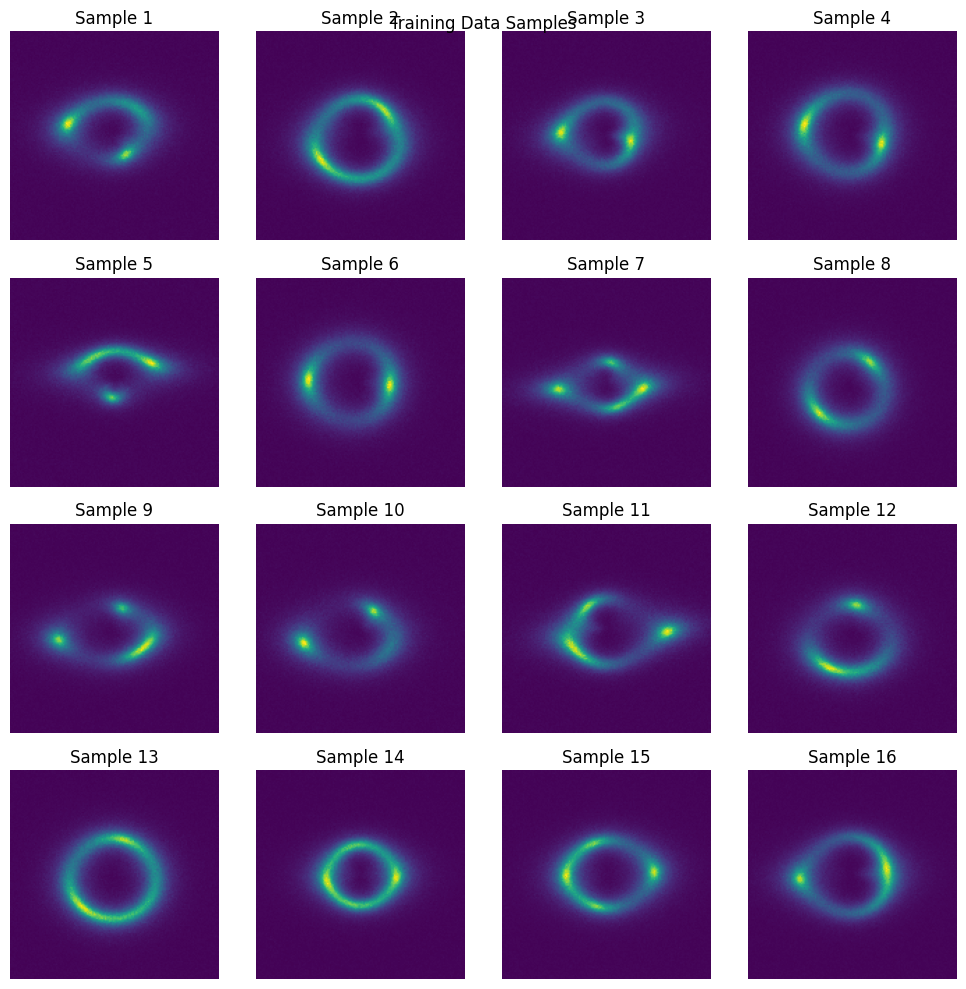

Preparing dataloaders...
Training batches: 140
Initializing models...
Generator parameters: 505,025
Discriminator parameters: 99,649
Starting GAN training...


<ipython-input-7-d3d572ba6e7b>:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
<ipython-input-7-d3d572ba6e7b>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


Epoch 1/100:   0%|          | 0/140 [00:00<?, ?it/s]

<ipython-input-7-d3d572ba6e7b>:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-7-d3d572ba6e7b>:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 - D Loss: 6.0962, G Loss: 0.6860


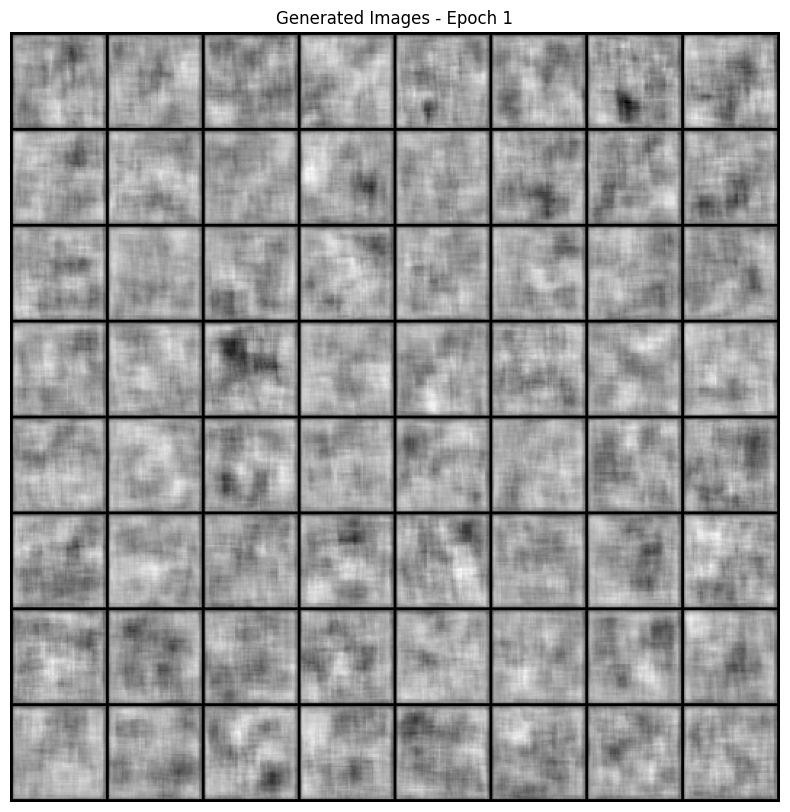

Epoch 2/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2/100 - D Loss: 2.0893, G Loss: 0.6862


Epoch 3/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3/100 - D Loss: 2.0569, G Loss: 0.6881


Epoch 4/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4/100 - D Loss: 2.3380, G Loss: 0.6862


Epoch 5/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5/100 - D Loss: 2.9497, G Loss: 0.6886
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 34.1MB/s]


FID Score: 320.3586
Calculating Inception Score...


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception Score: 1.2017 ± 0.0286


Epoch 6/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6/100 - D Loss: 3.0182, G Loss: 0.6797


Epoch 7/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7/100 - D Loss: 3.1832, G Loss: 0.6748


Epoch 8/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8/100 - D Loss: 3.3674, G Loss: 0.6749


Epoch 9/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9/100 - D Loss: 3.3714, G Loss: 0.6856


Epoch 10/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10/100 - D Loss: 3.1033, G Loss: 0.6875


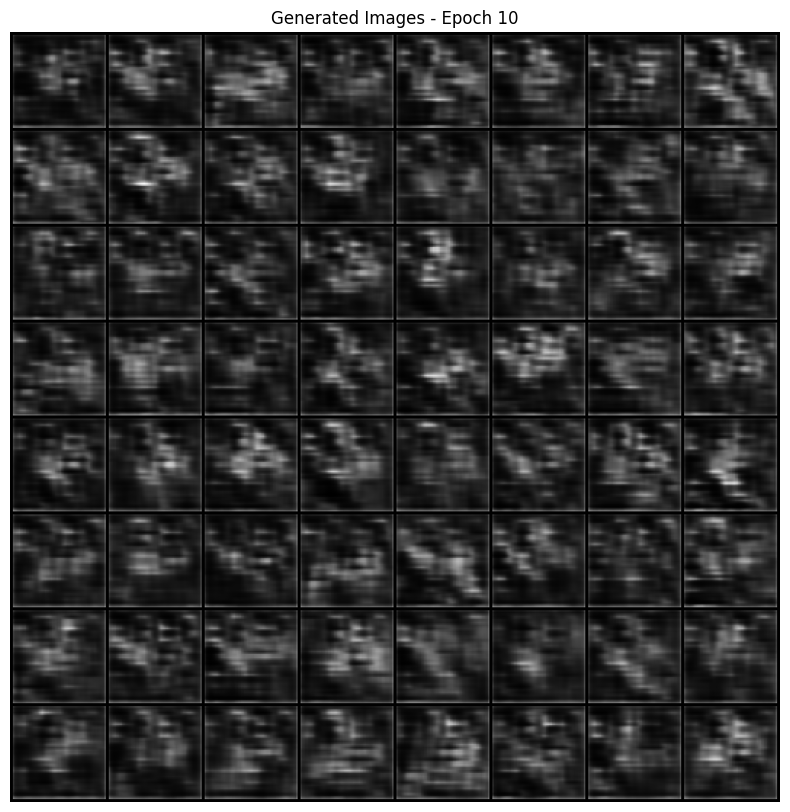

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 401.7391
Calculating Inception Score...
Inception Score: 1.3852 ± 0.0388


Epoch 11/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11/100 - D Loss: 3.0402, G Loss: 0.6891


Epoch 12/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12/100 - D Loss: 2.9513, G Loss: 0.6893


Epoch 13/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13/100 - D Loss: 2.9971, G Loss: 0.6932


Epoch 14/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 14/100 - D Loss: 3.1014, G Loss: 0.6914


Epoch 15/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 15/100 - D Loss: 3.3653, G Loss: 0.6939
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 362.9518
Calculating Inception Score...
Inception Score: 1.3555 ± 0.0349


Epoch 16/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 16/100 - D Loss: 3.5508, G Loss: 0.6950


Epoch 17/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 17/100 - D Loss: 3.9155, G Loss: 0.6962


Epoch 18/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 18/100 - D Loss: 3.7836, G Loss: 0.6985


Epoch 19/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 19/100 - D Loss: 3.7777, G Loss: 0.6949


Epoch 20/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 20/100 - D Loss: 3.9707, G Loss: 0.6928


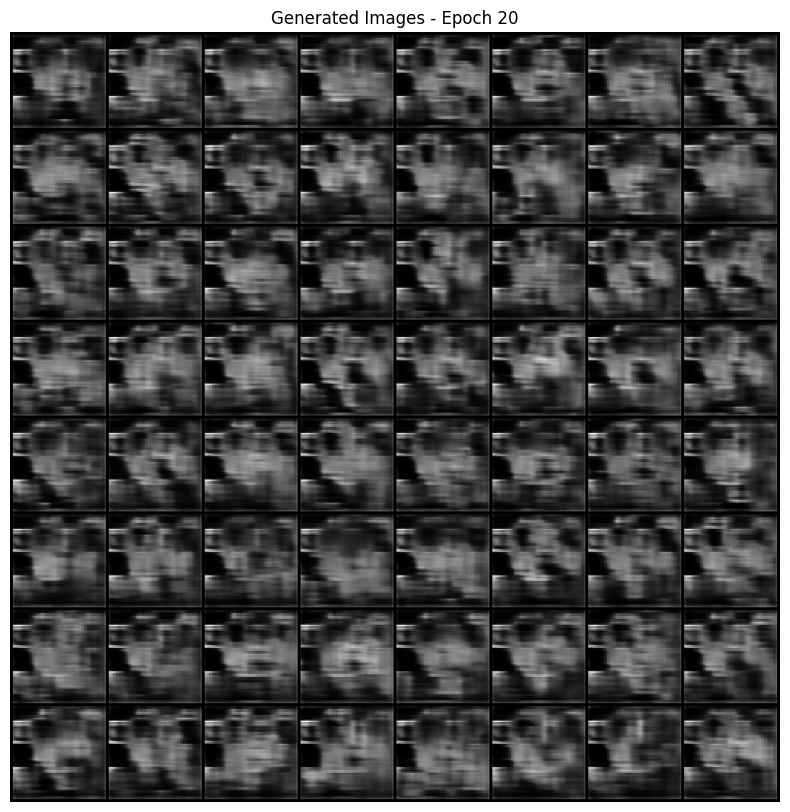

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 366.2947
Calculating Inception Score...
Inception Score: 1.4233 ± 0.0568


Epoch 21/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 21/100 - D Loss: 3.8931, G Loss: 0.6939


Epoch 22/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 22/100 - D Loss: 4.3013, G Loss: 0.6927


Epoch 23/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 23/100 - D Loss: 4.3881, G Loss: 0.6948


Epoch 24/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 24/100 - D Loss: 4.2281, G Loss: 0.6968


Epoch 25/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 25/100 - D Loss: 4.1466, G Loss: 0.6932
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 373.1646
Calculating Inception Score...
Inception Score: 1.3087 ± 0.0537


Epoch 26/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 26/100 - D Loss: 4.0825, G Loss: 0.6939


Epoch 27/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 27/100 - D Loss: 3.9525, G Loss: 0.6904


Epoch 28/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 28/100 - D Loss: 3.8398, G Loss: 0.6900


Epoch 29/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 29/100 - D Loss: 3.9147, G Loss: 0.6939


Epoch 30/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 30/100 - D Loss: 3.6453, G Loss: 0.6948


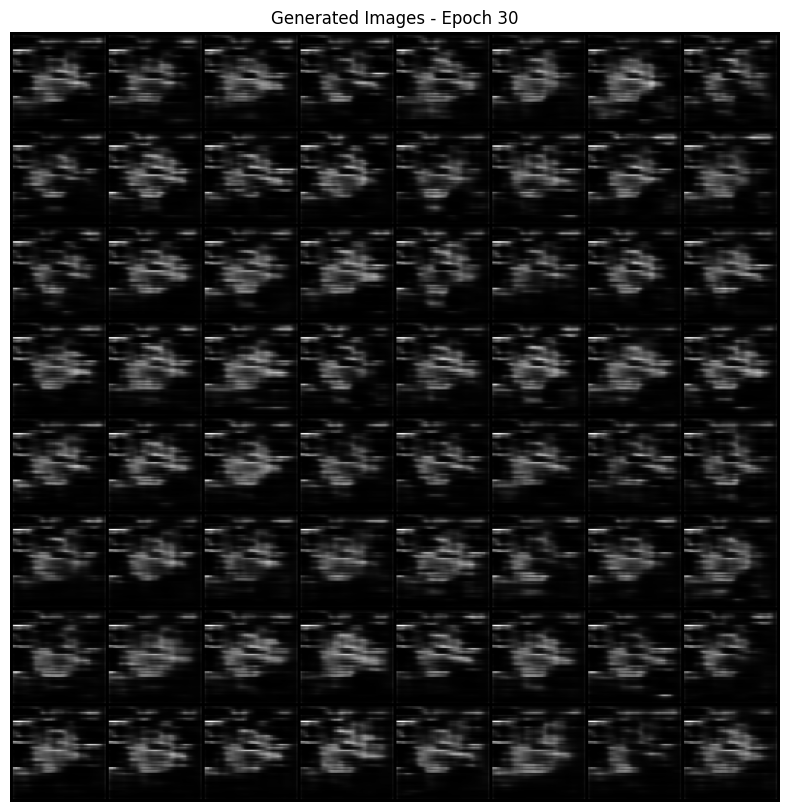

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 388.2731
Calculating Inception Score...
Inception Score: 1.2361 ± 0.0323


Epoch 31/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 31/100 - D Loss: 3.8329, G Loss: 0.6999


Epoch 32/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 32/100 - D Loss: 3.9654, G Loss: 0.6966


Epoch 33/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 33/100 - D Loss: 4.0841, G Loss: 0.6969


Epoch 34/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 34/100 - D Loss: 4.0169, G Loss: 0.6982


Epoch 35/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 35/100 - D Loss: 3.9698, G Loss: 0.6958
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 358.2472
Calculating Inception Score...
Inception Score: 1.3067 ± 0.0235


Epoch 36/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 36/100 - D Loss: 3.9220, G Loss: 0.6963


Epoch 37/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 37/100 - D Loss: 3.8339, G Loss: 0.6971


Epoch 38/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 38/100 - D Loss: 3.7543, G Loss: 0.6959


Epoch 39/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 39/100 - D Loss: 3.6356, G Loss: 0.6949


Epoch 40/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 40/100 - D Loss: 3.7398, G Loss: 0.6955


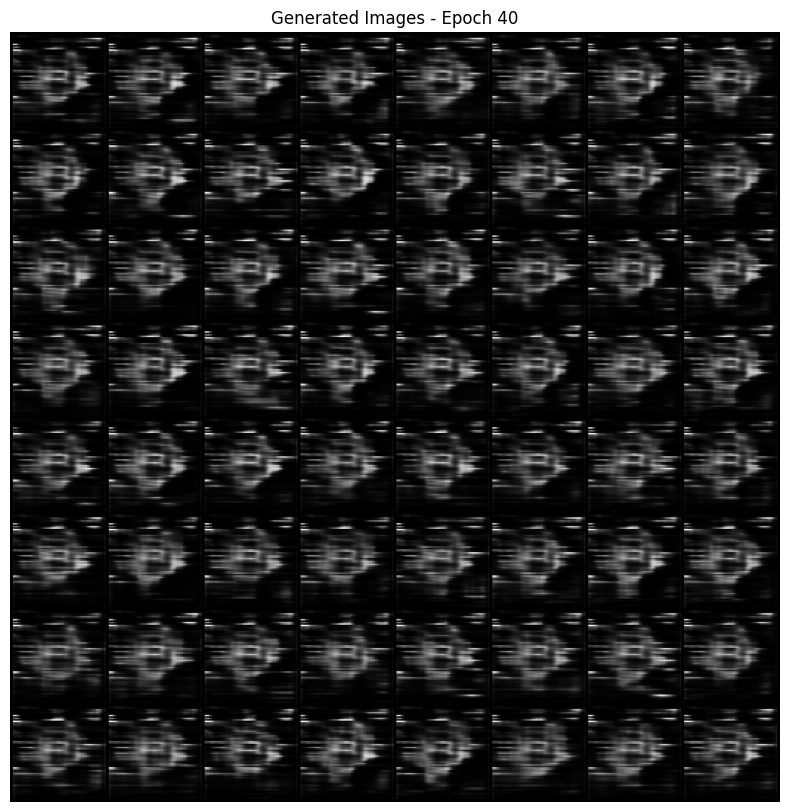

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 365.9124
Calculating Inception Score...
Inception Score: 1.2766 ± 0.0137


Epoch 41/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 41/100 - D Loss: 3.6595, G Loss: 0.6971


Epoch 42/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 42/100 - D Loss: 3.8259, G Loss: 0.6924


Epoch 43/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 43/100 - D Loss: 3.7522, G Loss: 0.6950


Epoch 44/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 44/100 - D Loss: 3.8840, G Loss: 0.6959


Epoch 45/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 45/100 - D Loss: 3.7861, G Loss: 0.6984
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 368.2084
Calculating Inception Score...
Inception Score: 1.2271 ± 0.0262


Epoch 46/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 46/100 - D Loss: 3.6919, G Loss: 0.6944


Epoch 47/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 47/100 - D Loss: 3.7255, G Loss: 0.6934


Epoch 48/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 48/100 - D Loss: 3.7408, G Loss: 0.6949


Epoch 49/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 49/100 - D Loss: 3.6300, G Loss: 0.6945


Epoch 50/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 50/100 - D Loss: 3.6516, G Loss: 0.6973


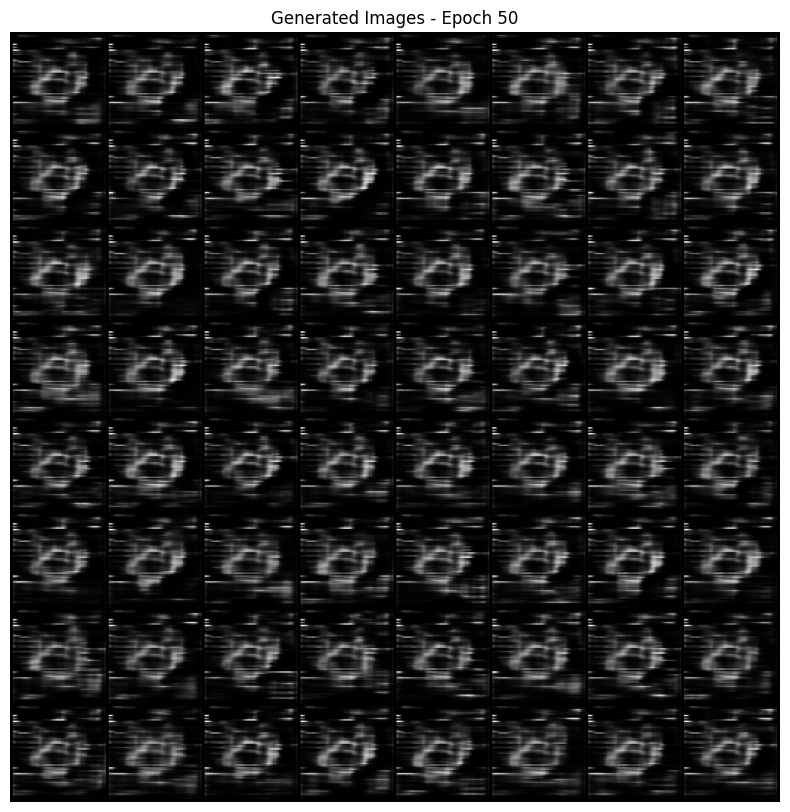

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 352.0537
Calculating Inception Score...
Inception Score: 1.2200 ± 0.0336


Epoch 51/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 51/100 - D Loss: 3.5658, G Loss: 0.6962


Epoch 52/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 52/100 - D Loss: 3.5818, G Loss: 0.6968


Epoch 53/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 53/100 - D Loss: 3.6496, G Loss: 0.6963


Epoch 54/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 54/100 - D Loss: 3.4704, G Loss: 0.6918


Epoch 55/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 55/100 - D Loss: 3.3624, G Loss: 0.6950
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 399.2799
Calculating Inception Score...
Inception Score: 1.1508 ± 0.0312


Epoch 56/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 56/100 - D Loss: 3.2789, G Loss: 0.6964


Epoch 57/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 57/100 - D Loss: 3.1750, G Loss: 0.6952


Epoch 58/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 58/100 - D Loss: 3.1071, G Loss: 0.6972


Epoch 59/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 59/100 - D Loss: 2.9665, G Loss: 0.6983


Epoch 60/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 60/100 - D Loss: 2.8989, G Loss: 0.6966


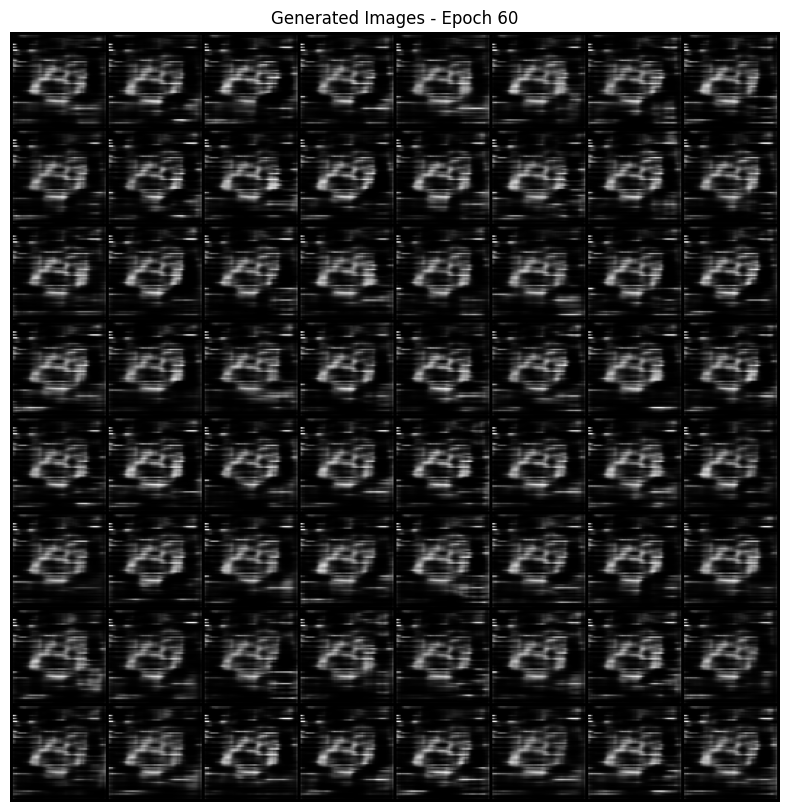

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 386.6264
Calculating Inception Score...
Inception Score: 1.2780 ± 0.0332


Epoch 61/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 61/100 - D Loss: 2.8750, G Loss: 0.6956


Epoch 62/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 62/100 - D Loss: 2.8883, G Loss: 0.6933


Epoch 63/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 63/100 - D Loss: 2.8853, G Loss: 0.6937


Epoch 64/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 64/100 - D Loss: 2.8342, G Loss: 0.6946


Epoch 65/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 65/100 - D Loss: 2.8008, G Loss: 0.6962
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 368.2214
Calculating Inception Score...
Inception Score: 1.2268 ± 0.0362


Epoch 66/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 66/100 - D Loss: 2.8422, G Loss: 0.6951


Epoch 67/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 67/100 - D Loss: 2.7852, G Loss: 0.6945


Epoch 68/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 68/100 - D Loss: 2.7930, G Loss: 0.6956


Epoch 69/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 69/100 - D Loss: 2.7992, G Loss: 0.6953


Epoch 70/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 70/100 - D Loss: 2.7959, G Loss: 0.6957


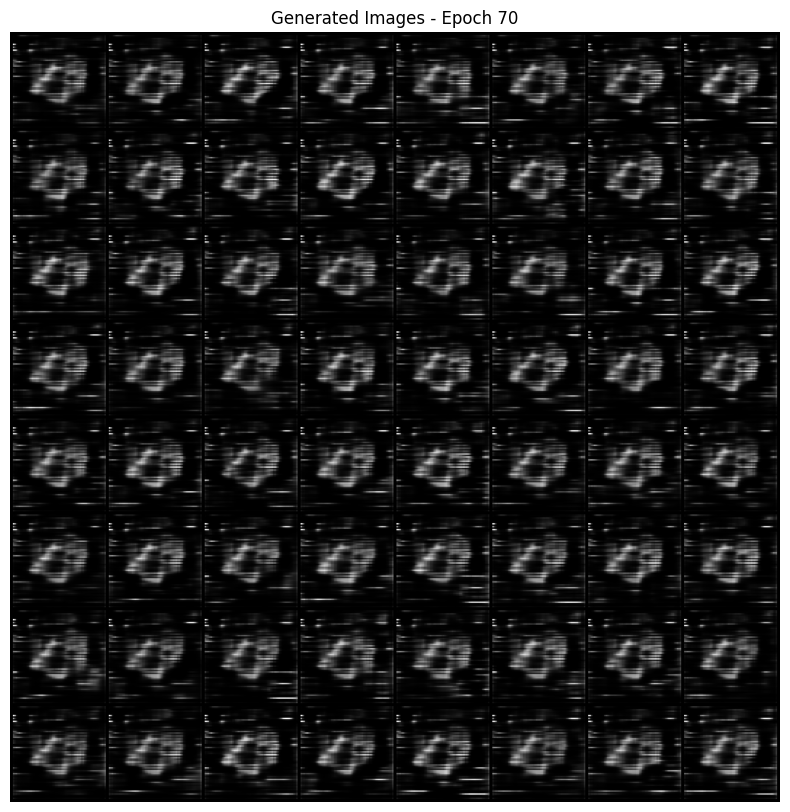

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 362.4995
Calculating Inception Score...
Inception Score: 1.2063 ± 0.0145


Epoch 71/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 71/100 - D Loss: 2.7862, G Loss: 0.6948


Epoch 72/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 72/100 - D Loss: 2.7541, G Loss: 0.6951


Epoch 73/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 73/100 - D Loss: 2.7448, G Loss: 0.6937


Epoch 74/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 74/100 - D Loss: 2.7063, G Loss: 0.6940


Epoch 75/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 75/100 - D Loss: 2.6621, G Loss: 0.6935
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 360.4485
Calculating Inception Score...
Inception Score: 1.1758 ± 0.0210


Epoch 76/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 76/100 - D Loss: 2.6676, G Loss: 0.6927


Epoch 77/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 77/100 - D Loss: 2.6960, G Loss: 0.6918


Epoch 78/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 78/100 - D Loss: 2.6830, G Loss: 0.6923


Epoch 79/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 79/100 - D Loss: 2.6890, G Loss: 0.6950


Epoch 80/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 80/100 - D Loss: 2.6971, G Loss: 0.6939


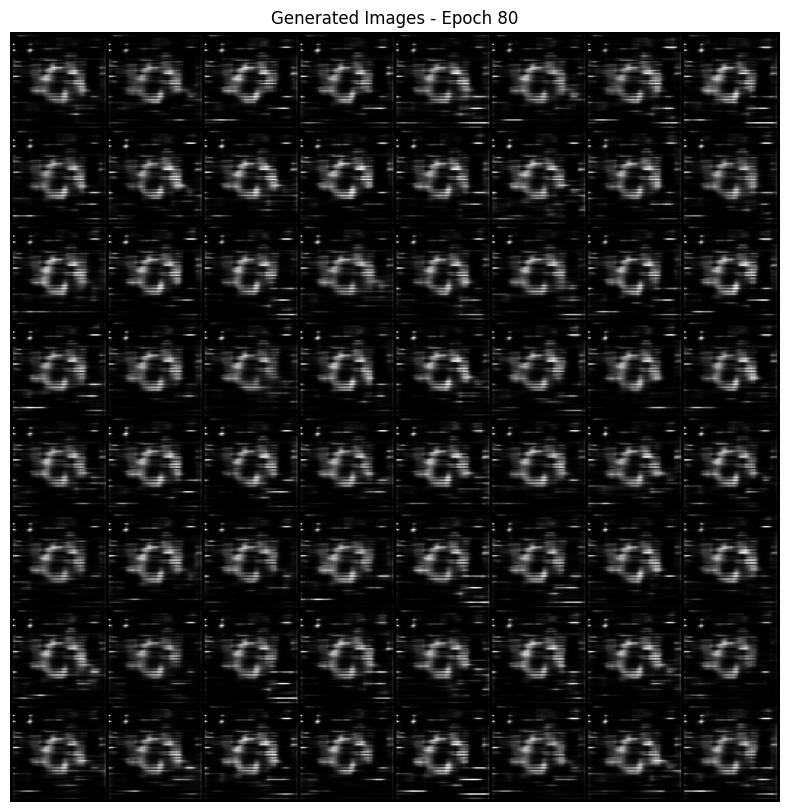

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 345.2215
Calculating Inception Score...
Inception Score: 1.1658 ± 0.0247


Epoch 81/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 81/100 - D Loss: 2.6284, G Loss: 0.6940


Epoch 82/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 82/100 - D Loss: 2.6532, G Loss: 0.6947


Epoch 83/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 83/100 - D Loss: 2.6038, G Loss: 0.6945


Epoch 84/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 84/100 - D Loss: 2.6125, G Loss: 0.6971


Epoch 85/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 85/100 - D Loss: 2.5954, G Loss: 0.6967
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 329.6479
Calculating Inception Score...
Inception Score: 1.1321 ± 0.0175


Epoch 86/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 86/100 - D Loss: 2.5918, G Loss: 0.6950


Epoch 87/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 87/100 - D Loss: 2.6103, G Loss: 0.6966


Epoch 88/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 88/100 - D Loss: 2.6111, G Loss: 0.6954


Epoch 89/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 89/100 - D Loss: 2.6073, G Loss: 0.6942


Epoch 90/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 90/100 - D Loss: 2.6128, G Loss: 0.6934


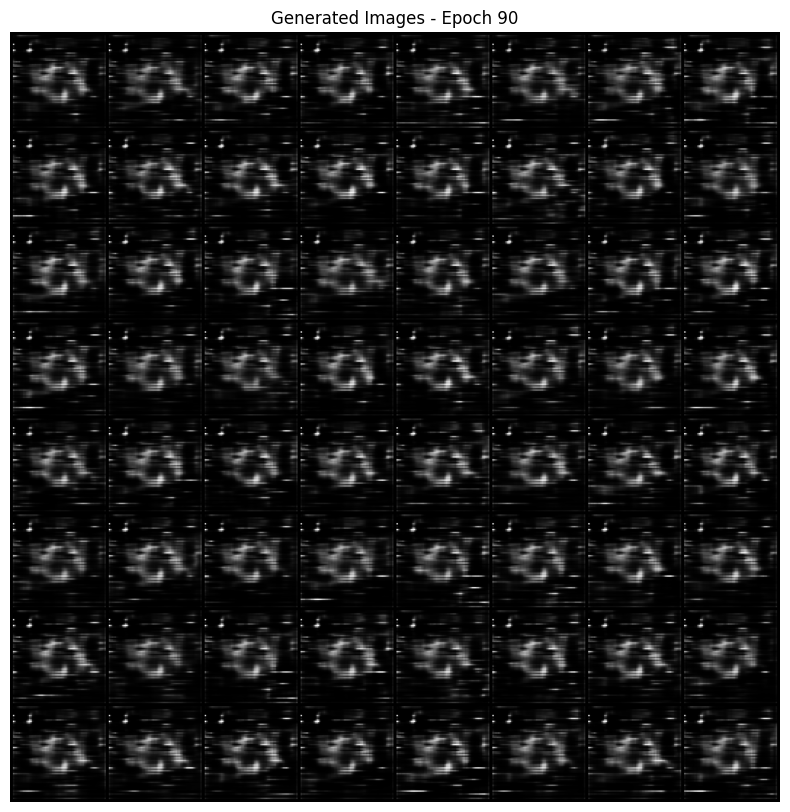

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 337.5534
Calculating Inception Score...
Inception Score: 1.1207 ± 0.0207


Epoch 91/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 91/100 - D Loss: 2.5552, G Loss: 0.6929


Epoch 92/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 92/100 - D Loss: 2.5998, G Loss: 0.6924


Epoch 93/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 93/100 - D Loss: 2.6075, G Loss: 0.6947


Epoch 94/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 94/100 - D Loss: 2.5465, G Loss: 0.6929


Epoch 95/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 95/100 - D Loss: 2.5565, G Loss: 0.6928
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 338.1042
Calculating Inception Score...
Inception Score: 1.1052 ± 0.0150


Epoch 96/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 96/100 - D Loss: 2.5952, G Loss: 0.6944


Epoch 97/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 97/100 - D Loss: 2.5888, G Loss: 0.6954


Epoch 98/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 98/100 - D Loss: 2.6366, G Loss: 0.6954


Epoch 99/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 99/100 - D Loss: 2.6664, G Loss: 0.6945


Epoch 100/100:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 100/100 - D Loss: 2.6036, G Loss: 0.6940


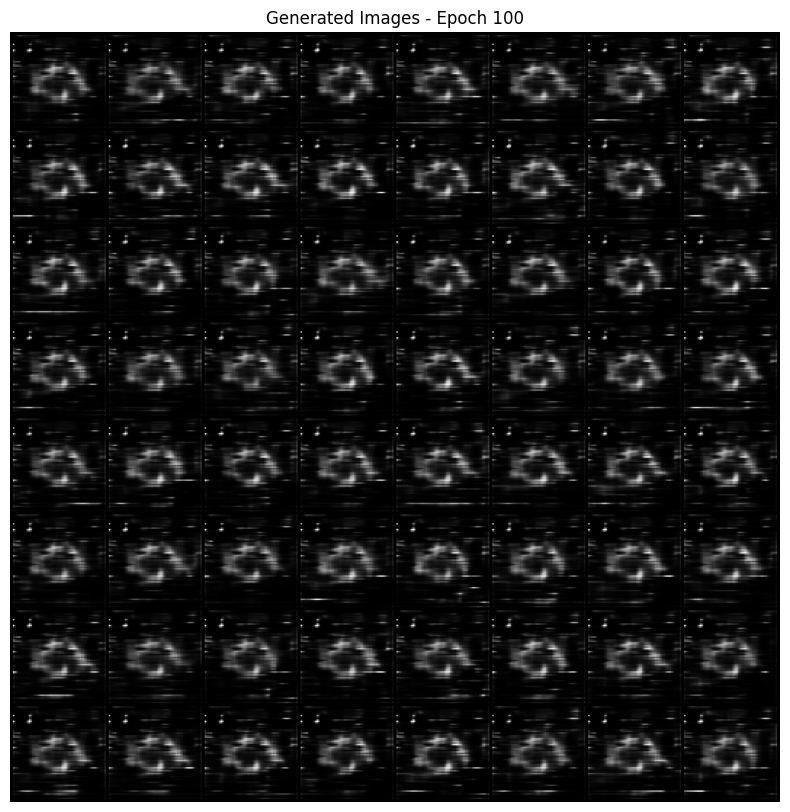

Generating samples for metrics calculation...


Loading real images:   0%|          | 0/140 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 333.5726
Calculating Inception Score...
Inception Score: 1.1165 ± 0.0123


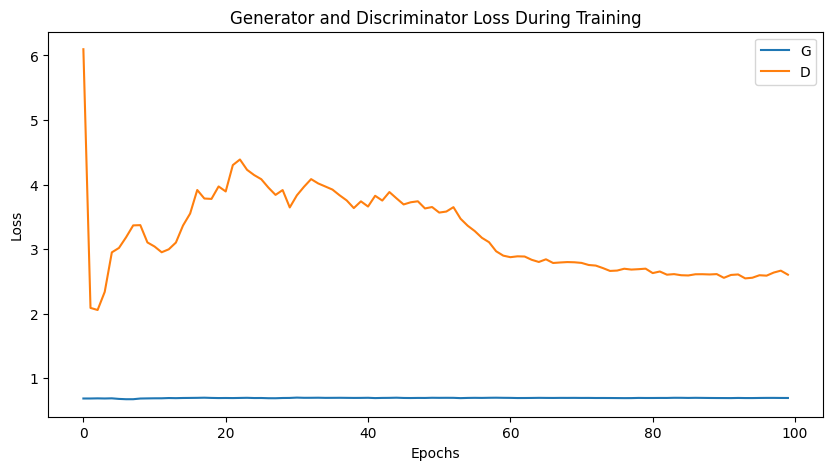

Training complete!
Performing final evaluation...
Generating samples for metrics calculation...


Loading real images:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating FID score...
FID Score: 330.2589
Calculating Inception Score...
Inception Score: 1.1339 ± 0.0108

Final Metrics:
FID Score: 330.2589 (lower is better)
Inception Score: 1.1339 ± 0.0108 (higher is better)


In [9]:
# Section 8: Main Execution
# Purpose: Run the complete GAN pipeline

def main():
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Load and preprocess data
    print("Loading dataset...")
    data = load_data()
    print(f"Dataset shape: {data.shape}")
    
    # Visualize samples
    print("Visualizing dataset samples...")
    visualize_samples(data, num_samples=16, title="Training Data Samples")
    
    # Prepare dataloaders
    print("Preparing dataloaders...")
    train_loader, val_loader = prepare_dataloaders(
        data, 
        batch_size=config['batch_size'], 
        image_size=config['image_size']
    )
    print(f"Training batches: {len(train_loader)}")
    
    # Initialize models
    print("Initializing models...")
    generator = Generator(
        latent_dim=config['latent_dim'],
        img_size=config['image_size'],
        channels=1  # Grayscale images
    ).to(device)
    
    discriminator = Discriminator(
        img_size=config['image_size'],
        channels=1  # Grayscale images
    ).to(device)
    
    # Print model summaries
    print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
    
    # Train GAN
    print("Starting GAN training...")
    generator, discriminator, G_losses, D_losses = train_gan(
        generator, discriminator, train_loader, device, config
    )
    
    print("Training complete!")
    
    # Final evaluation
    print("Performing final evaluation...")
    ema = EMA(generator, decay=0.999)
    ema.apply_shadow()
    metrics = evaluate_metrics(
        generator, val_loader, device, config['latent_dim'], n_samples=1000
    )
    ema.restore()
    
    print("\nFinal Metrics:")
    print(f"FID Score: {metrics['fid']:.4f} (lower is better)")
    print(f"Inception Score: {metrics['is_mean']:.4f} ± {metrics['is_std']:.4f} (higher is better)")
    
    return {
        "generator": generator,
        "discriminator": discriminator,
        "losses": {
            "G_losses": G_losses,
            "D_losses": D_losses
        },
        "metrics": metrics
    }

# Run the main function
if __name__ == "__main__":
    results = main()
